In [11]:

# Import matplotlib library
import matplotlib.pyplot as plt
 
# Import scikit-learn library
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import seaborn as sns

In [12]:
# this command will download the LFW_people's dataset to hard disk.
dataset = fetch_lfw_people(min_faces_per_person = 50, resize = 0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = dataset.images.shape



In [13]:
# Instead of providing 2D data, X has data already in the form of a vector that
# is required in this approach.
X = dataset.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = dataset.target
target_names = dataset.target_names
n_classes = target_names.shape[0]

# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)


Number of Data Samples:  1560
Size of a data sample:  1850
Number of Class Labels:  12


In [14]:
print(target_names)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Jacques Chirac' 'Jean Chretien'
 'John Ashcroft' 'Junichiro Koizumi' 'Serena Williams' 'Tony Blair']


In [15]:
from sklearn.metrics import roc_curve

def roc(X,y,model,title):
    fpr = {}
    tpr = {}
    thresh ={}
    colors = ['blue','green','red','yellow','pink','cyan','black','pink','olivedrab','darkviolet','orangered','olive']
    n_class = n_classes
    pred_prob = model.predict_proba(X)

    for i in range(n_class):    
        fpr[i], tpr[i], thresh[i] = roc_curve(y, pred_prob[:,i], pos_label=i)
        plt.plot(fpr[i], tpr[i], linestyle='--',color=colors[i], label=f'Class {i}')
        

    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.savefig('Multiclass ROC',dpi=300)

Visualing the train and test data

In [16]:
def plot_gallery(images, titles, h, w, n_row=6, n_col=9):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)




<AxesSubplot: ylabel='count'>

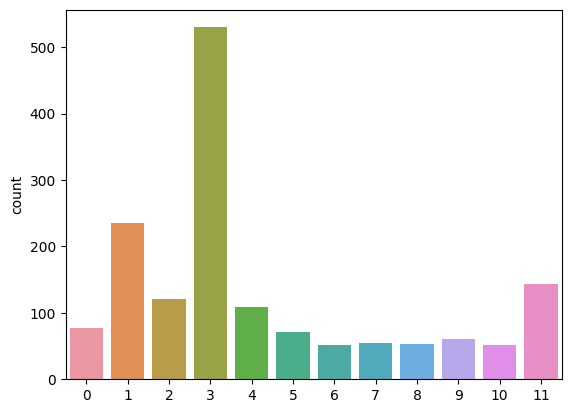

In [17]:
sns.countplot(x ="target",data = dataset)

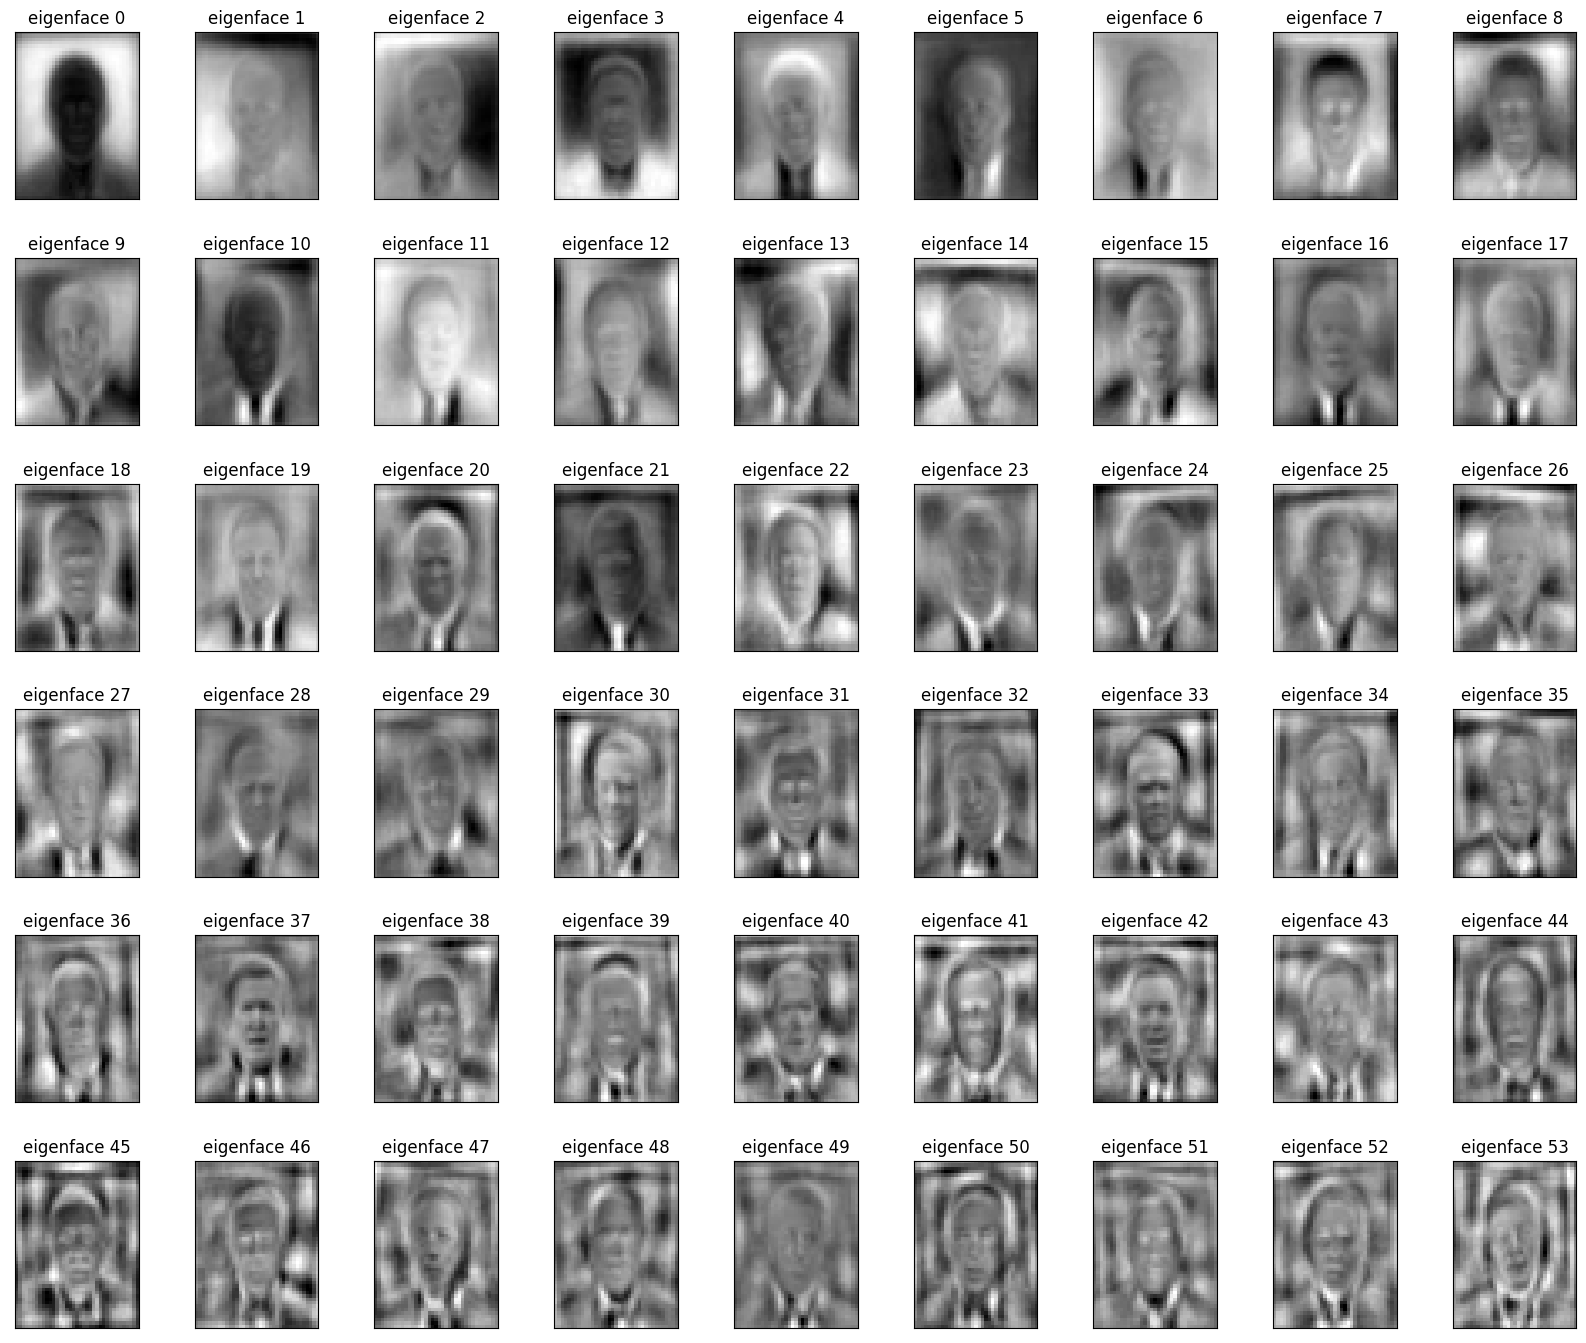

In [18]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

split data into training and testing data

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
	X, y, test_size = 0.25, random_state = 42)
print("size of training Data is % d and Testing Data is % d" %(
		y_train.shape[0], y_test.shape[0]))


size of training Data is  1170 and Testing Data is  390


SVM with PCA

One technique of dimensionality reduction is called principal component analysis (PCA). The idea behind PCA is that we want to select the hyperplane such that when all the points are projected onto it, they are maximally spread out. In other words, we want the axis of maximal variance! A potential axis is the x-axis or y-axis, but, in both cases, that’s not the best axis. However, if we pick a line that cuts through our data diagonally, that is the axis where the data would be most spread!

we should choose the component with highest variance as the principal component as it can represent the data more accurately.

In [20]:
from sklearn.decomposition import PCA as RandomizedPCA
n_components = 150

pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("Fitting the classifier to the training set")

param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }

grid_svm = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)

grid_svm = grid_svm.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")

print(grid_svm.best_estimator_)
print("Predicting the people names on the testing set")

y_pred_svm = grid_svm.predict(X_test_pca)

print(classification_report(y_test, y_pred_svm, target_names=target_names))


Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.001)
Predicting the people names on the testing set
                   precision    recall  f1-score   support

     Ariel Sharon       0.59      0.62      0.61        16
     Colin Powell       0.74      0.85      0.79        66
  Donald Rumsfeld       0.57      0.63      0.60        27
    George W Bush       0.83      0.88      0.85       140
Gerhard Schroeder       0.67      0.50      0.57        24
      Hugo Chavez       0.69      0.65      0.67        17
   Jacques Chirac       0.60      0.60      0.60        10
    Jean Chretien       0.64      0.64      0.64        14
    John Ashcroft       1.00      0.56      0.72        16
Junichiro Koizumi       0.82      0.82      0.82        11
  Serena Williams       0.89      0.89      0.89         9
       Tony Blair       0.81      0.62      0.70        40

         accuracy                           0.76    

<AxesSubplot: >

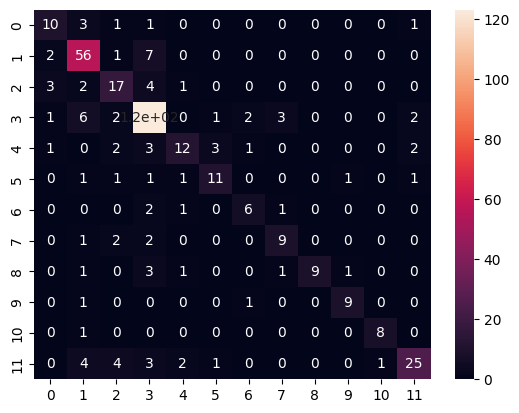

In [21]:


cm = confusion_matrix(y_test, y_pred_svm) 
sns.heatmap(cm, annot=True)

Qualitative evaluation of the predictions using matplotlib

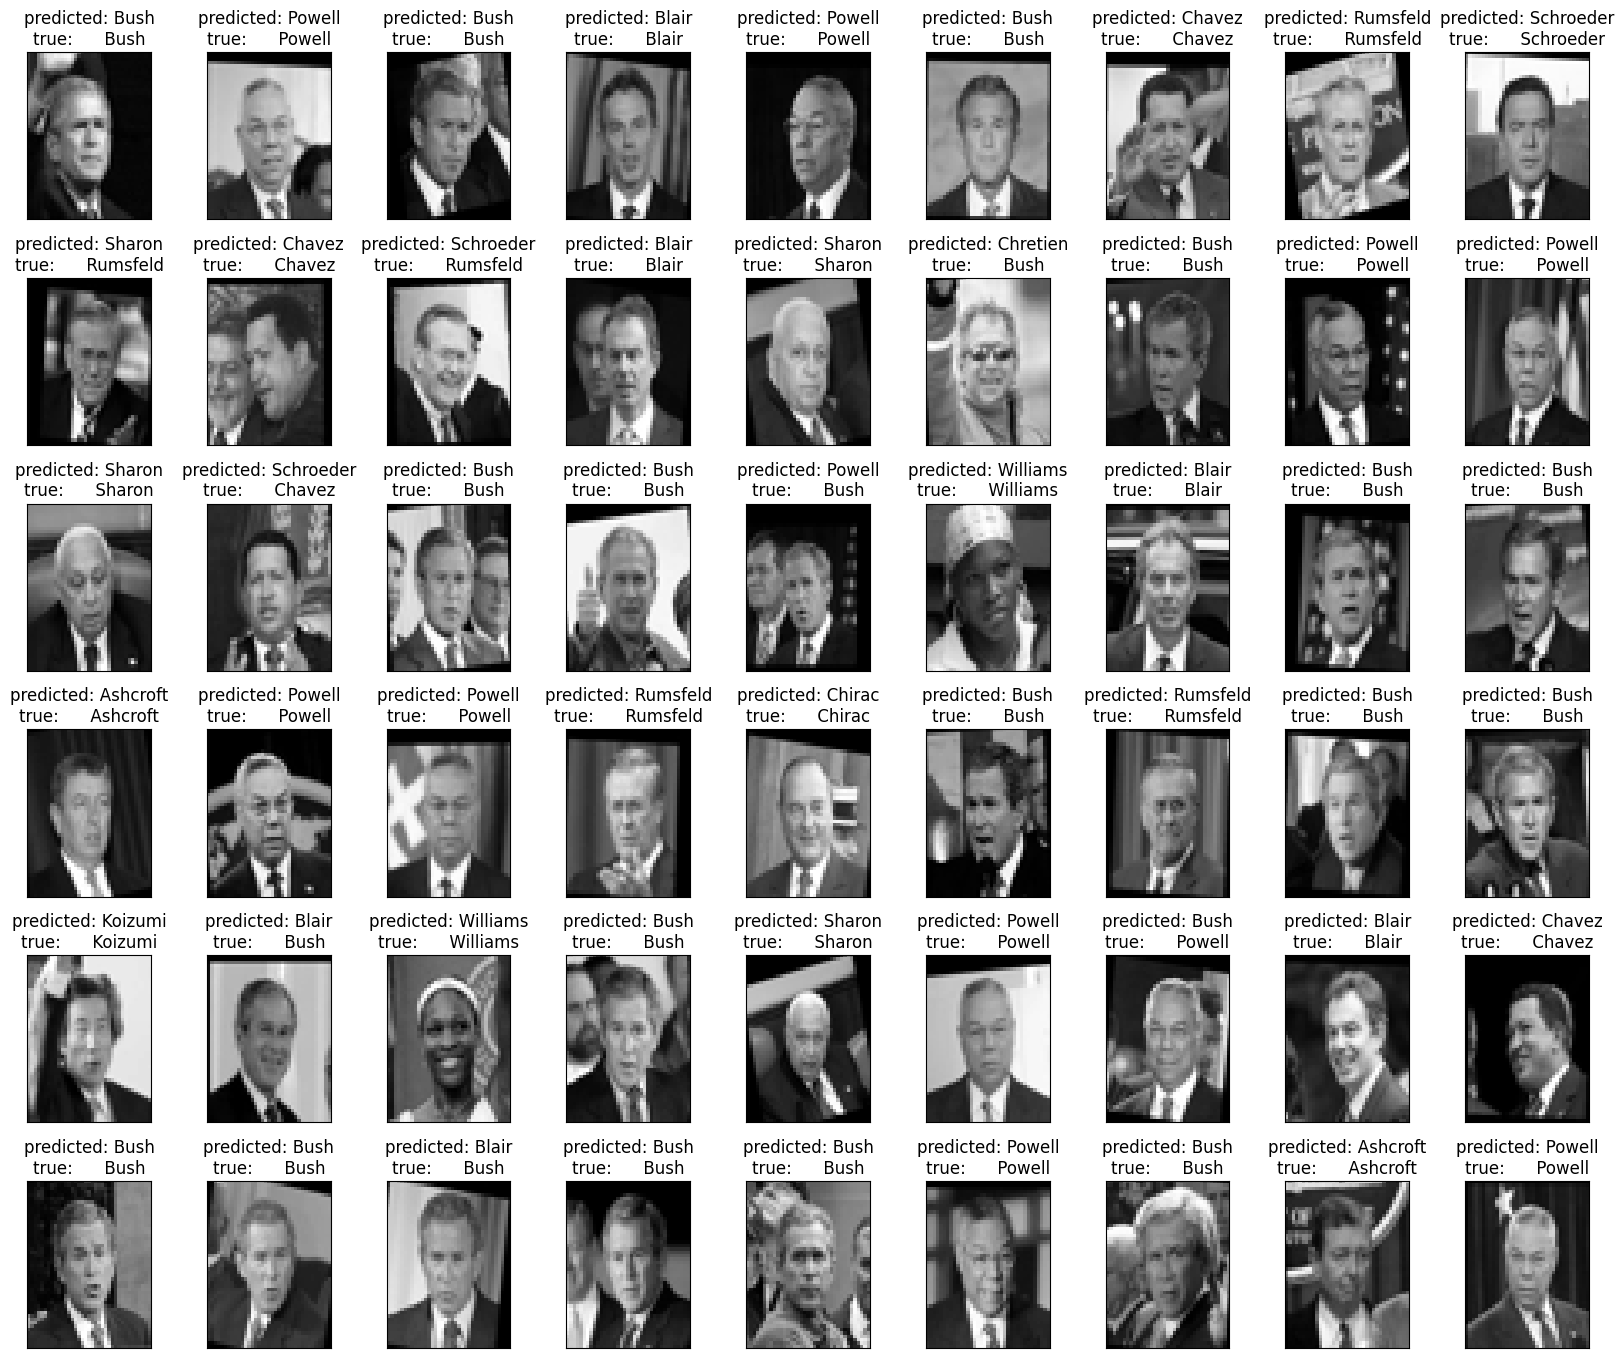

In [22]:
#plot the result of the prediction on a portion of the test set
prediction_titles_svm = [
    title(y_pred_svm, y_test, target_names, i) for i in range(y_pred_svm.shape[0])
]

plot_gallery(X_test, prediction_titles_svm, h, w)

KNN

In [23]:
knn = KNeighborsClassifier()
from sklearn.model_selection import GridSearchCV
k_range = list(range(1, 70))
param_grid = dict(n_neighbors=k_range)
  
# defining parameter range
grid_knn = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)

# fitting the model for grid search
grid_knn=grid_knn.fit(X_train_pca, y_train)
print(grid_knn.best_estimator_)
y_pred_knn=grid_knn.predict(X_test_pca)
print(classification_report(y_test, y_pred_knn, target_names=target_names))

Fitting 10 folds for each of 69 candidates, totalling 690 fits
KNeighborsClassifier(n_neighbors=11)
                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.12      0.22        16
     Colin Powell       0.53      0.47      0.50        66
  Donald Rumsfeld       0.12      0.04      0.06        27
    George W Bush       0.48      0.84      0.61       140
Gerhard Schroeder       1.00      0.08      0.15        24
      Hugo Chavez       0.00      0.00      0.00        17
   Jacques Chirac       0.22      0.20      0.21        10
    Jean Chretien       1.00      0.14      0.25        14
    John Ashcroft       0.00      0.00      0.00        16
Junichiro Koizumi       0.58      0.64      0.61        11
  Serena Williams       0.00      0.00      0.00         9
       Tony Blair       0.38      0.47      0.42        40

         accuracy                           0.47       390
        macro avg       0.44      0.25      0.25       390
     weighted

c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot: >

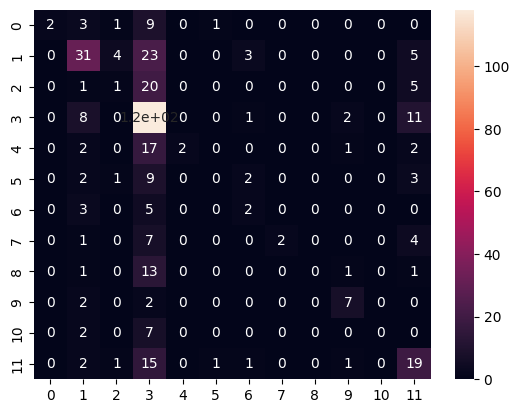

In [24]:
cm = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm, annot=True)

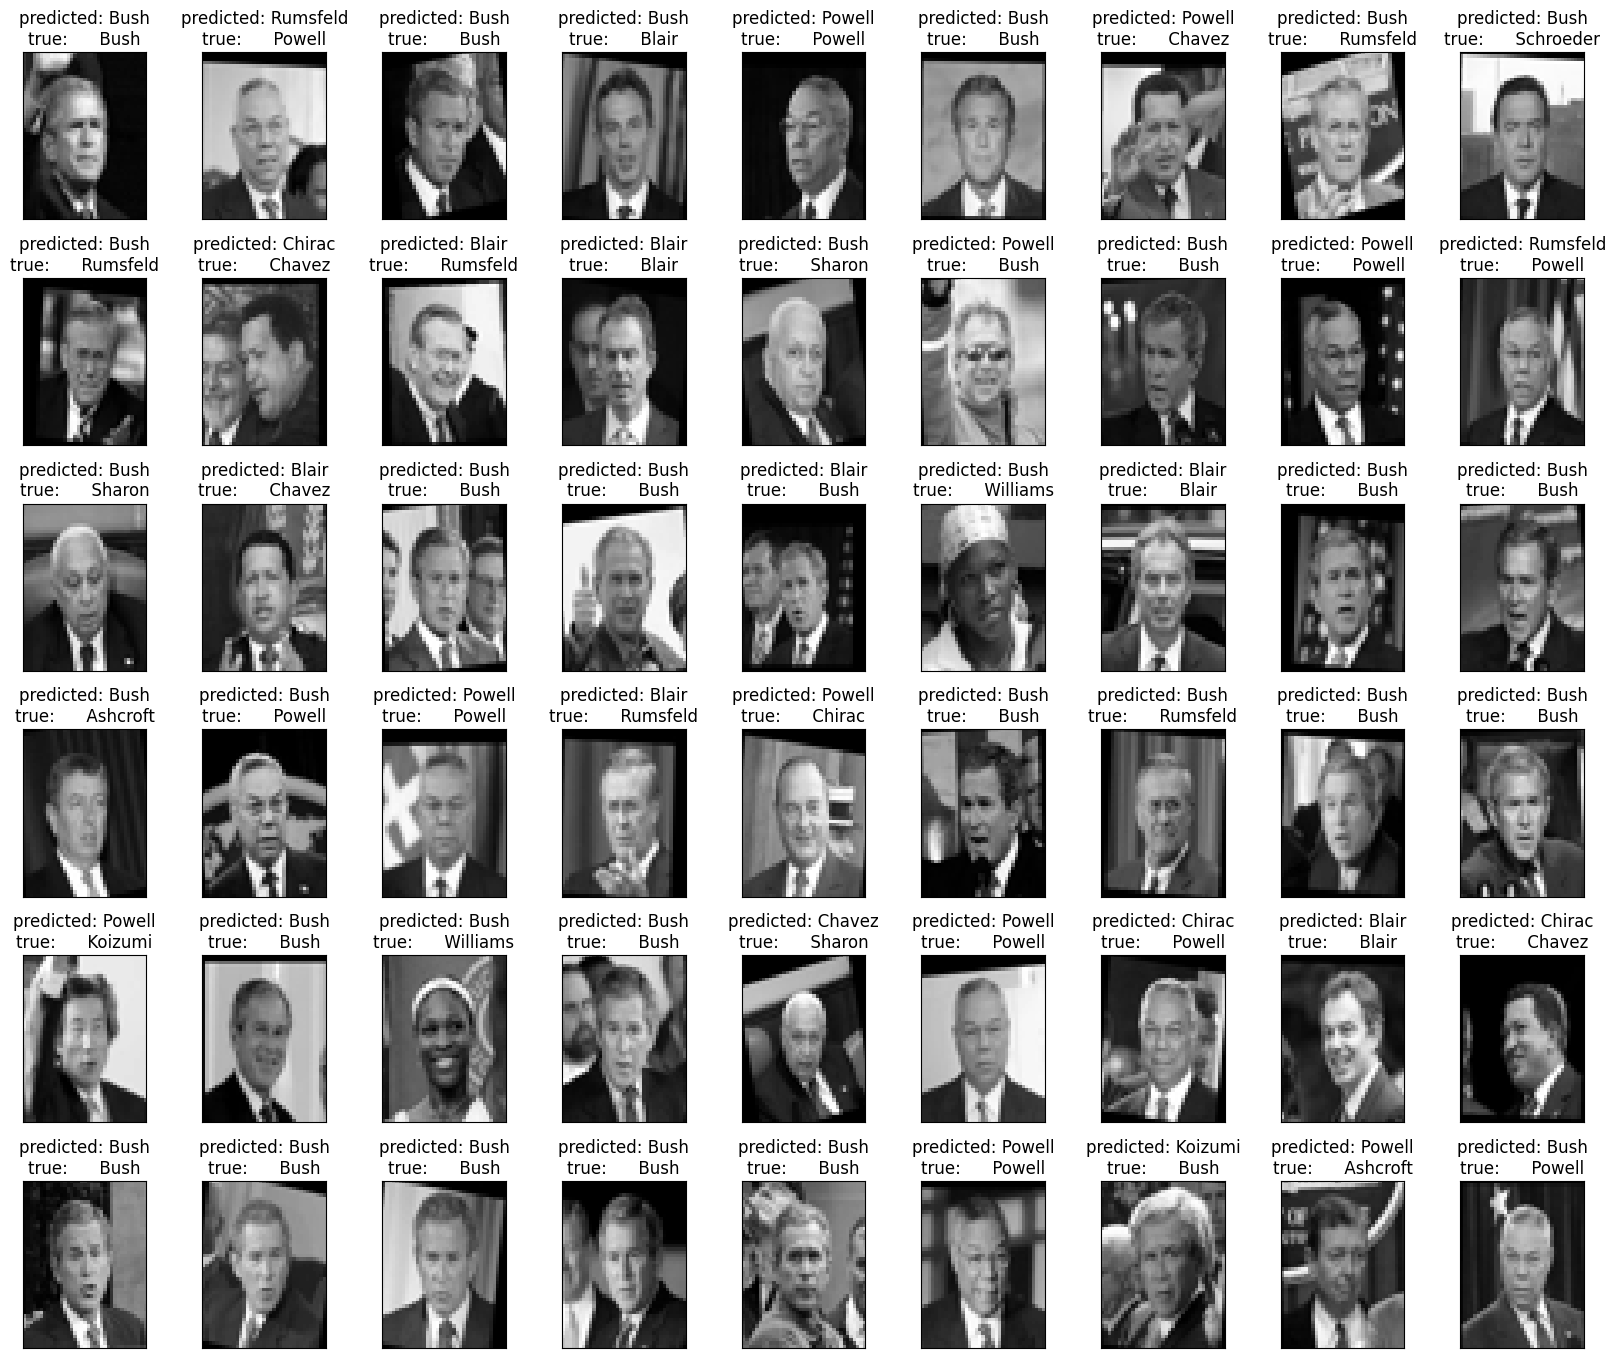

In [25]:
#plot the result of the prediction on a portion of the test set
prediction_titles = [
    title(y_pred_knn, y_test, target_names, i) for i in range(y_pred_knn.shape[0])
]

plot_gallery(X_test, prediction_titles, h, w)

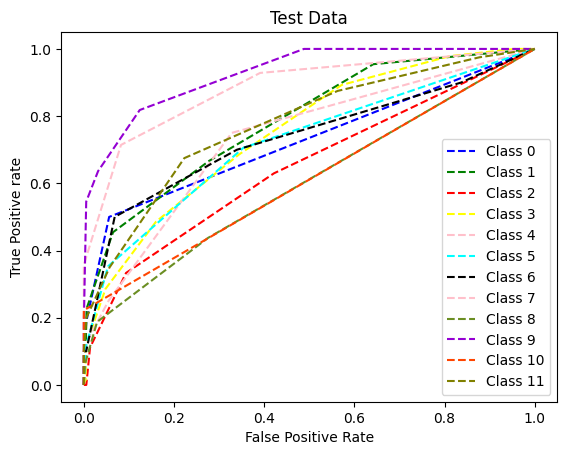

In [26]:

roc(X_test_pca,y_test,grid_knn,"Test Data")



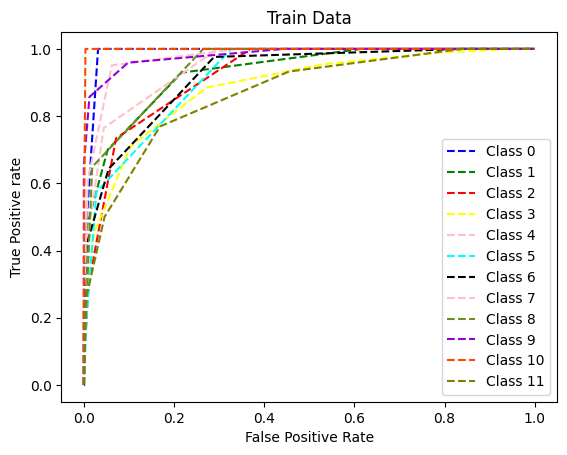

In [27]:
roc(X_train_pca,y_train,grid_knn,"Train Data")

In [28]:


from hmmlearn.hmm import GaussianHMM
hmm = GaussianHMM(n_components=4, covariance_type="diag", n_iter=1000).fit(X_train_pca)


Predicting people's names on the test set
                   precision    recall  f1-score   support

     Ariel Sharon       0.07      0.62      0.12        16
     Colin Powell       0.14      0.09      0.11        66
  Donald Rumsfeld       0.09      0.19      0.12        27
    George W Bush       0.36      0.35      0.35       140
Gerhard Schroeder       0.00      0.00      0.00        24
      Hugo Chavez       0.00      0.00      0.00        17
   Jacques Chirac       0.00      0.00      0.00        10
    Jean Chretien       0.00      0.00      0.00        14
    John Ashcroft       0.00      0.00      0.00        16
Junichiro Koizumi       0.00      0.00      0.00        11
  Serena Williams       0.00      0.00      0.00         9
       Tony Blair       0.00      0.00      0.00        40

         accuracy                           0.18       390
        macro avg       0.05      0.10      0.06       390
     weighted avg       0.16      0.18      0.16       390



c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot: >

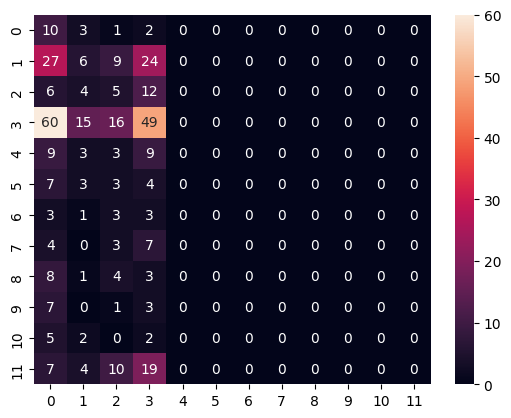

In [29]:
print("Predicting people's names on the test set")

y_pred_hmm = hmm.predict(X_test_pca)


print(classification_report(y_test, y_pred_hmm, target_names=target_names))
cm = confusion_matrix(y_test, y_pred_hmm)
sns.heatmap(cm, annot=True)

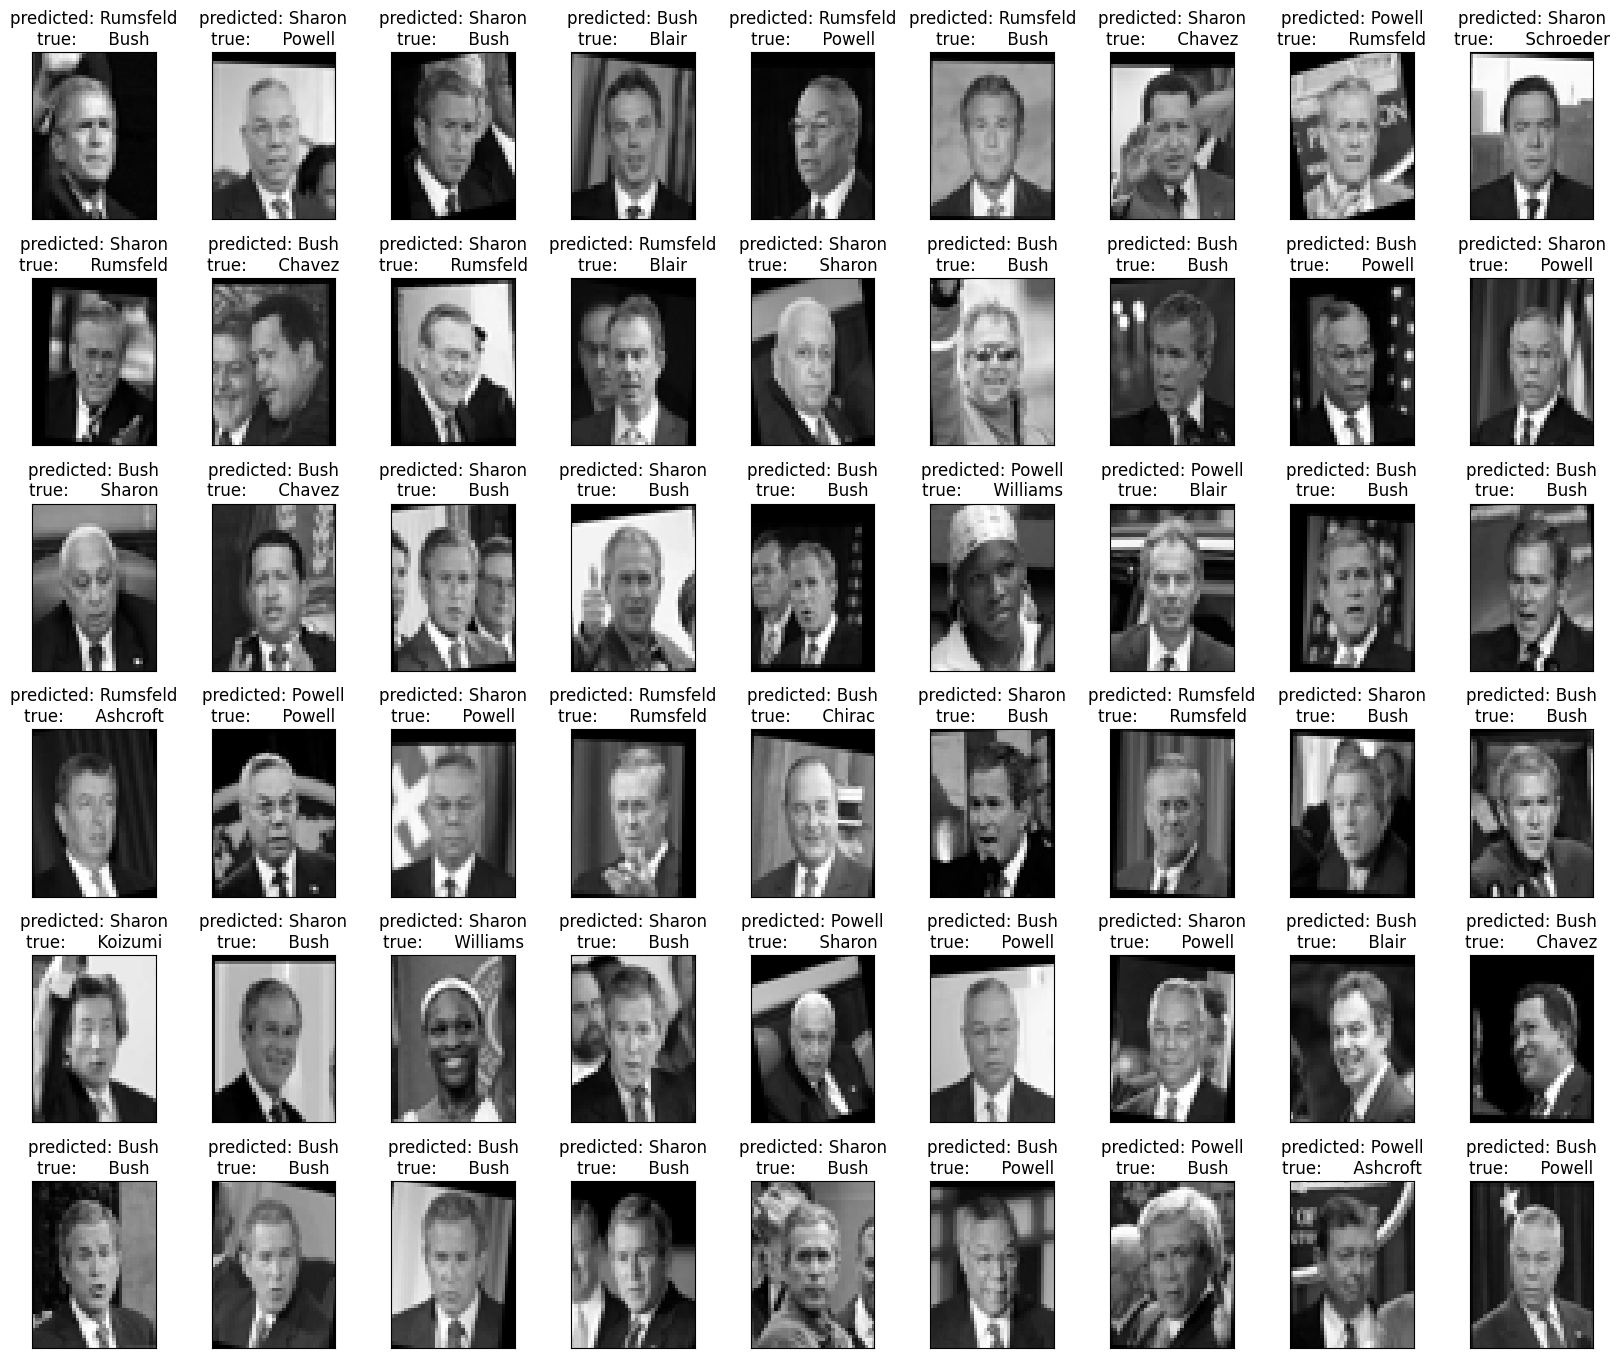

In [30]:
#plot the result of the prediction on a portion of the test set
prediction_titles = [
    title(y_pred_hmm, y_test, target_names, i) for i in range(y_pred_hmm.shape[0])
]

plot_gallery(X_test, prediction_titles, h, w)